# **Sentiment Analysis using RNN-**

## **Data loading and Preprocessing-**

In [1]:
import torch
import torchtext
from torchtext.data import get_tokenizer
import torchtext.datasets as datasets
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.datasets import IMDB
from IPython.display import HTML, IFrame
import torch.nn as nn
import time
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
!pip install torchtext==0.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [5]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 8.77MB/s]


In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [7]:
print(vars(train_data.examples[64]))

{'text': ['This', 'movie', 'is', 'one', 'of', 'those', '"', 'WOW', '!', '"', 'movies', '.', 'Not', 'because', 'it', "'s", 'the', 'greatest', 'movie', 'of', 'all', 'time', ',', 'but', 'because', 'it', 'surprised', 'me', '.', 'Not', 'only', 'was', 'it', 'a', 'T.V.', 'movie', ',', 'but', 'it', 'was', 'on', 'Elvis', '.', 'I', 'can', 'safely', 'say', 'as', 'many', 'impersonators', 'as', 'there', 'are', 'there', 'was', 'only', 'one', 'Elvis', ',', 'but', 'I', 'can', 'also', 'safely', 'say', 'that', 'Kurt', 'Russel', 'came', 'extremely', 'close', 'to', 'being', 'the', 'real', 'thing', '.', 'It', 'was', 'one', 'of', 'the', 'greatest', 'impersonations', 'that', 'I', 'have', 'ever', 'seen', '.', 'He', 'had', 'me', 'believing', 'that', 'it', 'was', 'really', 'him', '.', 'I', 'learned', 'a', 'lot', 'about', 'Elvis', "'", 'life', 'from', 'watching', 'this', 'movie', '.', 'And', 'do', "n't", 'led', 'the', 'television', 'part', 'of', 'it', 'let', 'you', 'stray', '-', 'it', "'s", 'actually', 'a', 'rea

In [8]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to build_vocab. TorchText handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the "glove.6B.100d" vectors". glove is the algorithm used to calculate the vectors, go here for more. 6B indicates these vectors were trained on 6 billion tokens and 100d indicates these vectors are 100-dimensional.

In [9]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.31MB/s]                           
100%|█████████▉| 399999/400000 [00:14<00:00, 26703.60it/s]


In [10]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [11]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202578), (',', 191178), ('.', 165170), ('and', 109337), ('a', 109323), ('of', 100474), ('to', 93260), ('is', 76551), ('in', 61056), ('I', 54070), ('it', 53598), ('that', 48992), ('"', 43994), ("'s", 43162), ('this', 42351), ('-', 37140), ('/><br', 35711), ('was', 34818), ('as', 30433), ('with', 29959)]


In [12]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a BucketIterator which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using torch.device, we then pass this device to the iterator.

In [11]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE,sort_within_batch = True,device = device)

In [12]:
def TabularFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Accuracy','Validation loss','Validation Accuracy'])

In [13]:
def GraphicalFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)

  plt.figure(figsize =(12,7))
  plt.plot(ep,eval_cost,label = "Evaluation Loss")
  plt.plot(ep,train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between value of Trainig and Validation Loss V/s Epochs",fontsize = 15)
  plt.show()
  print("\n\n__________________________________________________\n\n")
  plt.figure(figsize =(12,7))
  plt.plot(ep,train_acc,label = "Training Accuracy")
  plt.plot(ep,eval_acc,label = "Evaluation Accuracy")
  plt.ylabel("Accuracy",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between Trainig and Validation Accuracies V/s Epochs",fontsize = 15)
  plt.show()

## **Defining the Base model-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1,momentum=0.5, weight_decay=0.0001)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([256, 100])
rnn.weight_hh_l0 	 torch.Size([256, 256])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'momentum': 0.5, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,592,105 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4163, -0.2696,  0.1515,  ..., -0.8118, -0.5544,  0.4685],
        [ 0.4096,  0.0031, -0.5698,  ..., -0.0891,  0.4055,  0.2610],
        [-0.5360, -0.0865, -0.1737,  ..., -0.2267, -0.0245,  0.5324]],
       device='cuda:0')

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4163, -0.2696,  0.1515,  ..., -0.8118, -0.5544,  0.4685],
        [ 0.4096,  0.0031, -0.5698,  ..., -0.0891,  0.4055,  0.2610],
        [-0.5360, -0.0865, -0.1737,  ..., -0.2267, -0.0245,  0.5324]],
       device='cuda:0')


In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.682 | Train Acc: 55.61%
	 Val. Loss: 0.675 |  Val. Acc: 57.16%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.659 | Train Acc: 60.00%
	 Val. Loss: 0.671 |  Val. Acc: 58.75%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.641 | Train Acc: 63.30%
	 Val. Loss: 0.644 |  Val. Acc: 63.71%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.640 | Train Acc: 63.49%
	 Val. Loss: 0.632 |  Val. Acc: 64.55%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.630 | Train Acc: 64.86%
	 Val. Loss: 0.726 |  Val. Acc: 53.60%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.642 | Train Acc: 62.70%
	 Val. Loss: 0.638 |  Val. Acc: 64.07%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.637 | Train Acc: 63.54%
	 Val. Loss: 0.691 |  Val. Acc: 53.66%
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.668 | Train Acc: 59.63%
	 Val. Loss: 0.653 |  Val. Acc: 61.85%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.646 | Train Acc: 62.89%
	 Val. Loss: 0.671 |  Val. Acc: 59.18%
Epoch: 10 | Epoch Time: 0m 6

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.681709,55.611314,0.674595,57.163665
1,2,0.659177,60.003096,0.671114,58.748234
2,3,0.641242,63.299172,0.643827,63.709393
3,4,0.640103,63.492245,0.631995,64.548023
4,5,0.629585,64.858414,0.726285,53.601695
5,6,0.642074,62.703663,0.637890,64.066914
6,7,0.636681,63.543568,0.691310,53.659075
7,8,0.668306,59.627542,0.653077,61.846751
8,9,0.646298,62.888588,0.671422,59.176377
9,10,0.628099,65.094662,0.619932,65.735346


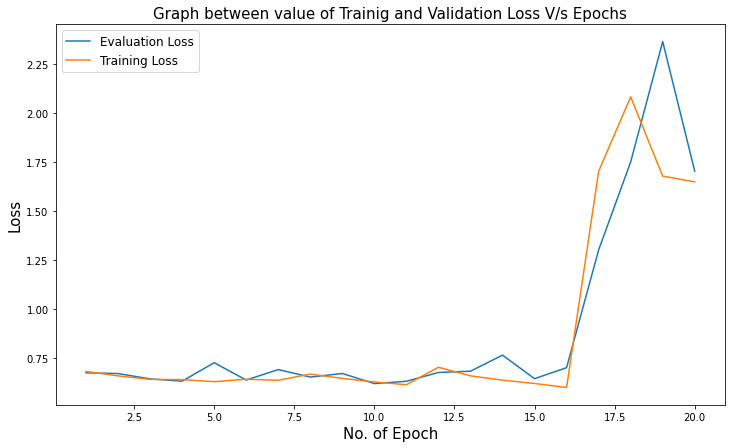



__________________________________________________




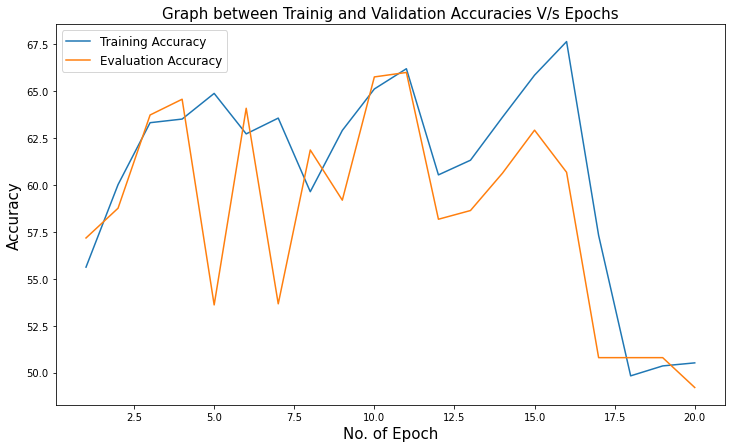

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

## **Trying the base model again with Adam Optimizer-**

In [19]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([256, 100])
rnn.weight_hh_l0 	 torch.Size([256, 256])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,592,105 trainable parameters


In [20]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 100

best_valid_loss = float('inf')
prev_epoch_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
patience = 3
i = 0
max_epochs = 50
# while i<patience:
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, valid_loss))
        torch.save(model.state_dict(), 'tut1-model.pt')

    if valid_loss_list[-1]<prev_epoch_valid_loss:
      i = 0
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on if condition and the value of i is = ", i)
    else:
      i = i + 1
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on else condition and the value of i is = ", i)
    if i>=patience:
      print("Early Stopping")
      print("Returning the model with best parameters")
      break
    if epoch >= max_epochs:
      print("Max Epochs reached")
      print("Returning the model with best parameters")
      break

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.688 | Train Acc: 54.97%
	 Val. Loss: 0.694 |  Val. Acc: 51.45%
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.69364082
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.695 | Train Acc: 50.81%
	 Val. Loss: 0.694 |  Val. Acc: 50.24%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.694 | Train Acc: 51.49%
	 Val. Loss: 0.689 |  Val. Acc: 52.40%
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.68851438
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.687 | Train Acc: 53.92%
	 Val. Loss: 0.682 |  Val. Acc: 55.65%
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.68191317
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.651 | Train Acc: 61.37%
	 Val. Loss: 0.656 |  Val. Acc: 64.30%
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.65569691
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.677 | Train Acc: 55.97%
	 Val. Loss: 0.664 |  Val. Acc: 61.54%
Epoch: 07 | Epoch Time: 0m 6s
	T

In [26]:
import pandas as pd
pd = TabularFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.688130,54.970184,0.693641,51.447740
1,2,0.694656,50.810577,0.693892,50.238347
2,3,0.694173,51.489181,0.688514,52.401130
3,4,0.687359,53.917655,0.681913,55.649718
4,5,0.651440,61.370894,0.655697,64.296434
5,6,0.677065,55.973019,0.663503,61.537783
6,7,0.602001,68.591958,0.571074,72.223694
7,8,0.560729,72.264403,0.633213,63.691737
8,9,0.512197,75.571070,0.665014,58.593750
9,10,0.590549,69.852222,0.612044,66.459216


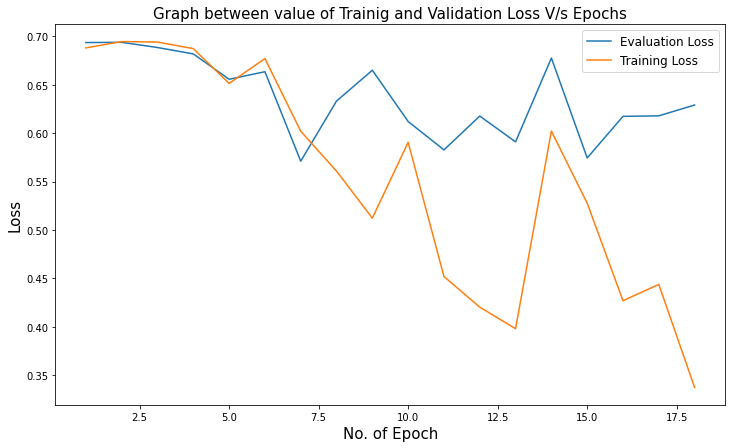



__________________________________________________




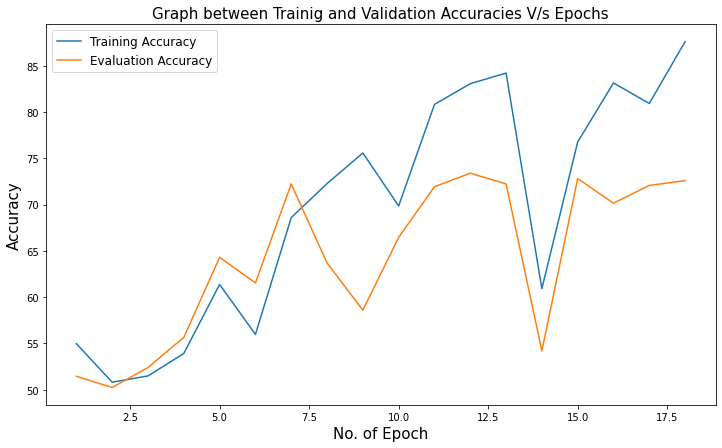

In [27]:
GraphicalFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

## **Increasing/Decraseing the number of epochs and the learning rate of the base model-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2,momentum=0.7, weight_decay=0.0001)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([256, 100])
rnn.weight_hh_l0 	 torch.Size([256, 256])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,592,105 trainable parameters


In [ ]:
N_EPOCHS = 50

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.688 | Train Acc: 53.52%
	 Val. Loss: 0.683 |  Val. Acc: 54.49%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.673 | Train Acc: 57.87%
	 Val. Loss: 0.661 |  Val. Acc: 60.17%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.647 | Train Acc: 62.30%
	 Val. Loss: 0.635 |  Val. Acc: 64.17%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.655 | Train Acc: 61.24%
	 Val. Loss: 0.667 |  Val. Acc: 59.55%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.651 | Train Acc: 61.58%
	 Val. Loss: 0.656 |  Val. Acc: 61.76%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.622 | Train Acc: 65.47%
	 Val. Loss: 0.648 |  Val. Acc: 61.27%
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.618 | Train Acc: 65.90%
	 Val. Loss: 0.582 |  Val. Acc: 70.58%
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.643 | Train Acc: 62.21%
	 Val. Loss: 0.638 |  Val. Acc: 62.83%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.629 | Train Acc: 64.16%
	 Val. Loss: 0.669 |  Val. Acc: 58.45%
Epoch: 10 | Epoch Time: 0m 7

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.688356,53.516847,0.683495,54.488877
1,2,0.673026,57.871970,0.661121,60.169492
2,3,0.646532,62.298781,0.635229,64.168432
3,4,0.655112,61.235662,0.667097,59.551554
4,5,0.650693,61.577001,0.655948,61.758475
5,6,0.622202,65.465328,0.647966,61.268538
6,7,0.618296,65.901981,0.582064,70.577331
7,8,0.642901,62.213243,0.638021,62.831038
8,9,0.629456,64.161887,0.668936,58.448093
9,10,0.650409,60.814488,0.652696,61.237641


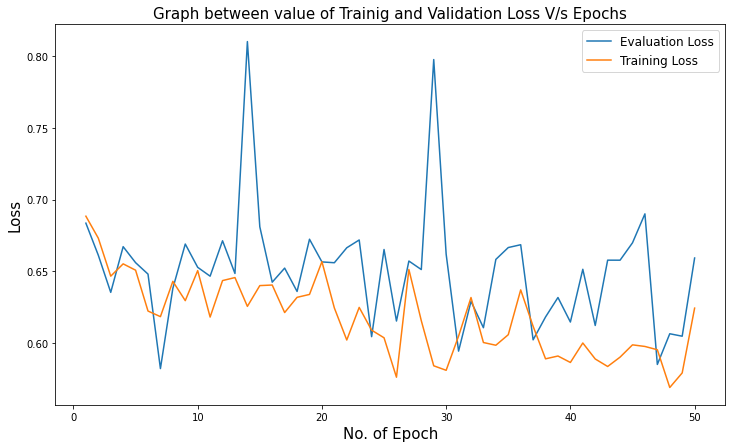



__________________________________________________




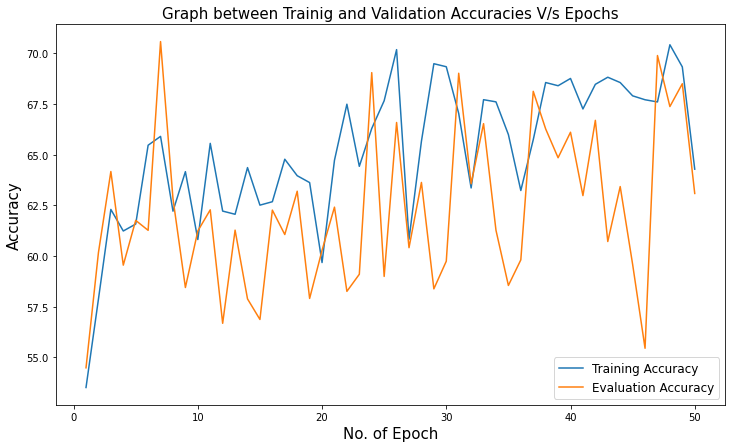

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

### **Reverting back to initial learning rate and now increasing epochs-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.7, weight_decay=0.0001)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([256, 100])
rnn.weight_hh_l0 	 torch.Size([256, 256])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,592,105 trainable parameters


In [ ]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.692 | Train Acc: 52.15%
	 Val. Loss: 0.690 |  Val. Acc: 53.36%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.690 | Train Acc: 53.88%
	 Val. Loss: 0.689 |  Val. Acc: 54.60%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.688 | Train Acc: 54.21%
	 Val. Loss: 0.687 |  Val. Acc: 54.83%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.687 | Train Acc: 54.61%
	 Val. Loss: 0.686 |  Val. Acc: 54.33%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.686 | Train Acc: 55.02%
	 Val. Loss: 0.685 |  Val. Acc: 55.47%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.684 | Train Acc: 55.51%
	 Val. Loss: 0.683 |  Val. Acc: 56.13%
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.683 | Train Acc: 56.37%
	 Val. Loss: 0.683 |  Val. Acc: 55.27%
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.681 | Train Acc: 56.40%
	 Val. Loss: 0.681 |  Val. Acc: 56.34%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.680 | Train Acc: 57.16%
	 Val. Loss: 0.679 |  Val. Acc: 57.16%
Epoch: 10 | Epoch Time: 0m 6

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.691834,52.154751,0.690438,53.363347
1,2,0.689959,53.876923,0.688507,54.603637
2,3,0.688393,54.206041,0.687099,54.828743
3,4,0.686979,54.606035,0.686206,54.334393
4,5,0.685598,55.022321,0.684689,55.473164
...,...,...,...,...,...
95,96,0.621229,65.290179,0.649051,61.683439
96,97,0.603983,66.821722,0.594014,68.229167
97,98,0.602852,67.317844,0.589366,68.454273
98,99,0.598752,67.719467,0.585993,69.381179


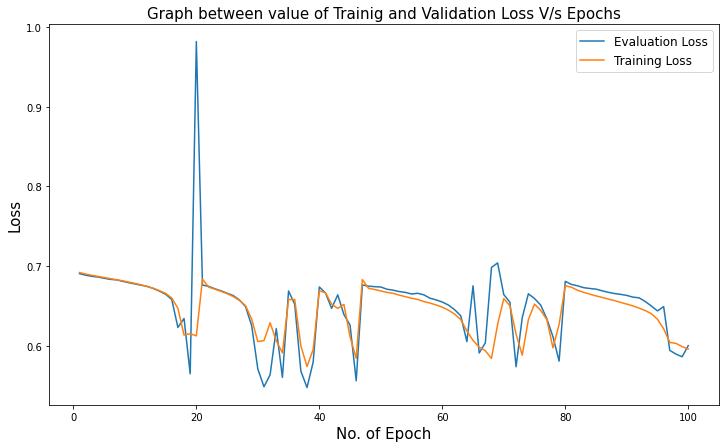



__________________________________________________




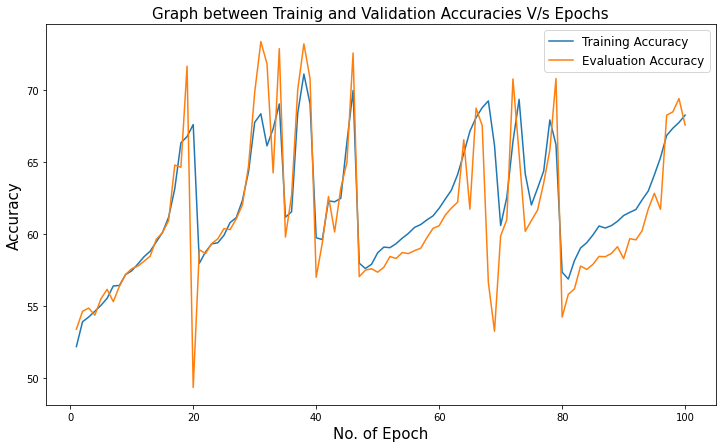

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

## **Adding learning rate scheduler-**

### **Adding Multistep LR-**

In [26]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.7, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,55,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Adjusting learning rate of group 0 to 1.0000e-03.
Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([256, 100])
rnn.weight_hh_l0 	 torch.Size([256, 256])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'initial_lr': 0.001, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,592,105 trainable parameters


In [17]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    lr_scheduler.step()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.692 | Train Acc: 52.15%
	 Val. Loss: 0.691 |  Val. Acc: 52.59%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.690 | Train Acc: 53.89%
	 Val. Loss: 0.689 |  Val. Acc: 53.39%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.688 | Train Acc: 54.81%
	 Val. Loss: 0.687 |  Val. Acc: 54.26%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.687 | Train Acc: 55.61%
	 Val. Loss: 0.686 |  Val. Acc: 54.99%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.685 | Train Acc: 55.80%
	 Val. Loss: 0.685 |  Val. Acc: 55.55%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.684 | Train Acc: 56.22%
	 Val. Loss: 0.683 |  Val. Acc: 56.49%
Adjusting learning rate of group 0 to 1.0000e-03.
Ep

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.692448,52.148234,0.691193,52.586511
1,2,0.690209,53.894845,0.689354,53.389831
2,3,0.688421,54.813771,0.687495,54.263771
3,4,0.686818,55.612943,0.686171,54.992055
4,5,0.685335,55.803571,0.684620,55.548199
...,...,...,...,...,...
95,96,0.535324,74.133212,0.542679,73.711158
96,97,0.535310,74.169056,0.542675,73.737641
97,98,0.535322,74.184535,0.542591,73.671434
98,99,0.535479,74.148690,0.542651,73.697917


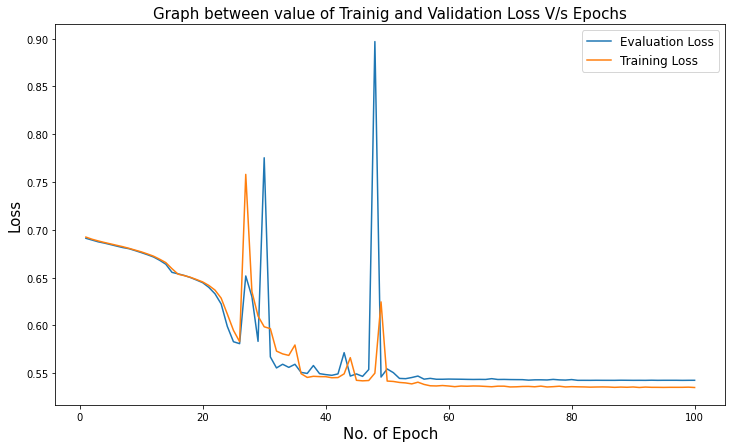



__________________________________________________




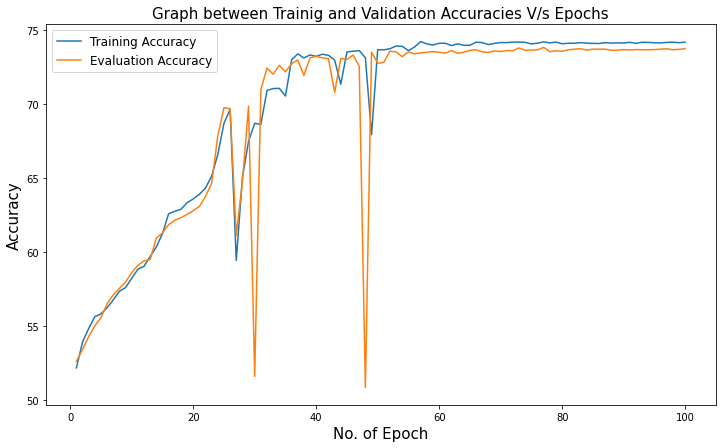

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

### **Adjusting the learning rate values again-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.7, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,55,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Adjusting learning rate of group 0 to 1.0000e-01.
Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([256, 100])
rnn.weight_hh_l0 	 torch.Size([256, 256])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'initial_lr': 0.1, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,592,105 trainable parameters


In [ ]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.680 | Train Acc: 56.46%
	 Val. Loss: 0.663 |  Val. Acc: 59.66%
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.662 | Train Acc: 60.10%
	 Val. Loss: 0.660 |  Val. Acc: 59.75%
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.653 | Train Acc: 61.29%
	 Val. Loss: 0.647 |  Val. Acc: 61.08%
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.637 | Train Acc: 63.73%
	 Val. Loss: 0.631 |  Val. Acc: 66.52%
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.654 | Train Acc: 61.63%
	 Val. Loss: 0.701 |  Val. Acc: 55.62%
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.657 | Train Acc: 63.77%
	 Val. Loss: 0.690 |  Val. Acc: 53.24%
Adjusting learning rate of group 0 to 1.0000e-01.
Ep

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.679709,56.456107,0.663230,59.657486
1,2,0.662009,60.098410,0.660154,59.745763
2,3,0.652998,61.286985,0.646719,61.083157
3,4,0.637382,63.734196,0.631165,66.521010
4,5,0.653731,61.632397,0.700612,55.623234
...,...,...,...,...,...
95,96,0.387903,82.540407,0.551555,74.894068
96,97,0.387790,82.564846,0.551000,74.814619
97,98,0.387574,82.643053,0.550240,74.814619
98,99,0.387583,82.537963,0.551512,75.066208


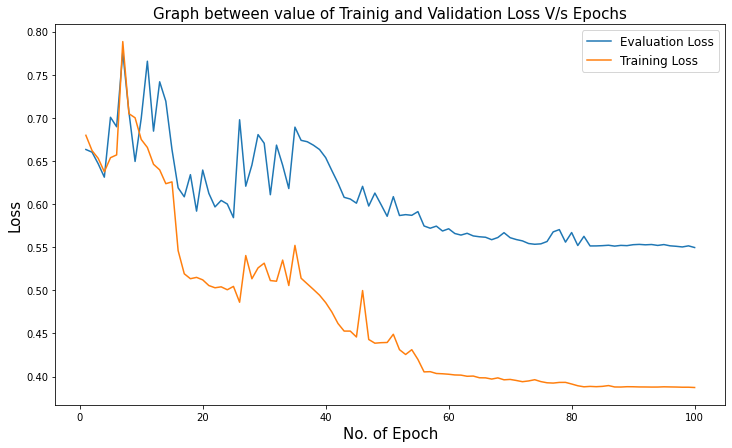



__________________________________________________




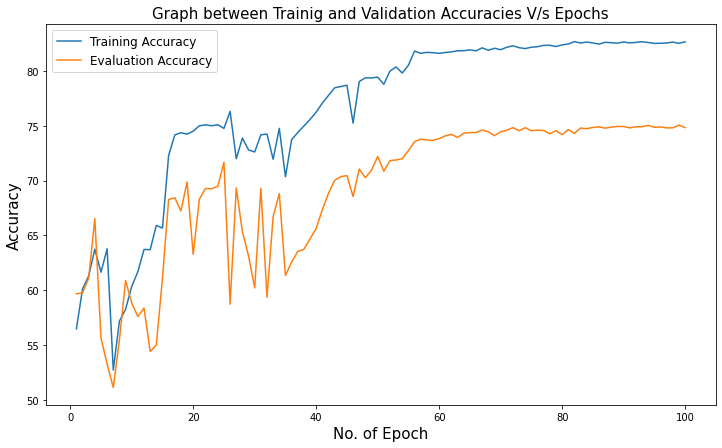

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

## **Increasing the number of layers in RNN-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn1(packed_embedded)
        packed_output, hidden = self.rnn2(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.7, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,55,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn1): RNN(100, 256)
  (rnn2): RNN(256, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Adjusting learning rate of group 0 to 1.0000e-02.
Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn1.weight_ih_l0 	 torch.Size([256, 100])
rnn1.weight_hh_l0 	 torch.Size([256, 256])
rnn1.bias_ih_l0 	 torch.Size([256])
rnn1.bias_hh_l0 	 torch.Size([256])
rnn2.weight_ih_l0 	 torch.Size([256, 256])
rnn2.weight_hh_l0 	 torch.Size([256, 256])
rnn2.bias_ih_l0 	 torch.Size([256])
rnn2.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'initial_lr': 0.01, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [ ]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.672 | Train Acc: 58.66%
	 Val. Loss: 0.671 |  Val. Acc: 57.34%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.645 | Train Acc: 62.30%
	 Val. Loss: 0.639 |  Val. Acc: 63.09%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.644 | Train Acc: 62.65%
	 Val. Loss: 0.678 |  Val. Acc: 56.36%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.666 | Train Acc: 59.10%
	 Val. Loss: 0.651 |  Val. Acc: 61.56%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.634 | Train Acc: 63.82%
	 Val. Loss: 0.674 |  Val. Acc: 57.13%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.641 | Train Acc: 63.34%
	 Val. Loss: 0.680 |  Val. Acc: 55.43%
Adjusting learning rate of group 0 to 1.0000e-

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.672218,58.657293,0.671064,57.335805
1,2,0.645325,62.297967,0.638950,63.087041
2,3,0.643963,62.648266,0.678301,56.360346
3,4,0.665775,59.097204,0.651329,61.555438
4,5,0.634105,63.821363,0.673660,57.128355
...,...,...,...,...,...
95,96,0.521678,74.566606,0.557972,72.771010
96,97,0.521763,74.567421,0.557926,72.771010
97,98,0.521654,74.603265,0.557979,72.810734
98,99,0.521496,74.583714,0.557927,72.837218


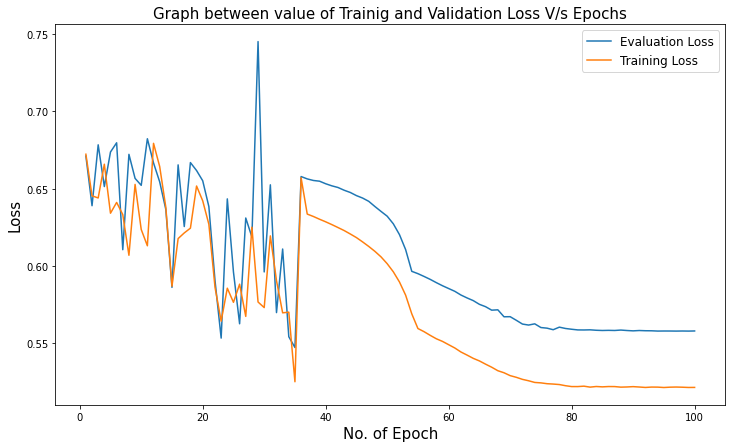



__________________________________________________




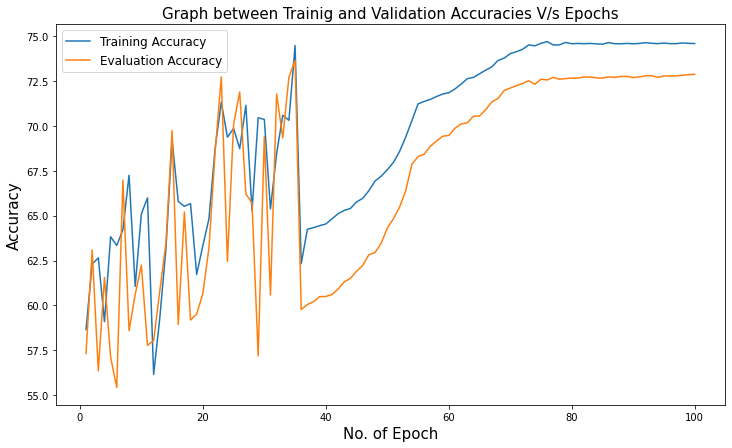

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

### **Adjusting the learning rate values again (starting from 0.001)-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn1(packed_embedded)
        packed_output, hidden = self.rnn2(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.7, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn1): RNN(100, 256)
  (rnn2): RNN(256, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Adjusting learning rate of group 0 to 1.0000e-03.
Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn1.weight_ih_l0 	 torch.Size([256, 100])
rnn1.weight_hh_l0 	 torch.Size([256, 256])
rnn1.bias_ih_l0 	 torch.Size([256])
rnn1.bias_hh_l0 	 torch.Size([256])
rnn2.weight_ih_l0 	 torch.Size([256, 256])
rnn2.weight_hh_l0 	 torch.Size([256, 256])
rnn2.bias_ih_l0 	 torch.Size([256])
rnn2.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'initial_lr': 0.001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

In [ ]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.692 | Train Acc: 51.67%
	 Val. Loss: 0.692 |  Val. Acc: 51.66%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.690 | Train Acc: 53.13%
	 Val. Loss: 0.690 |  Val. Acc: 53.65%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.689 | Train Acc: 54.51%
	 Val. Loss: 0.689 |  Val. Acc: 54.73%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.687 | Train Acc: 54.83%
	 Val. Loss: 0.687 |  Val. Acc: 55.30%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.686 | Train Acc: 56.16%
	 Val. Loss: 0.686 |  Val. Acc: 55.88%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.684 | Train Acc: 56.64%
	 Val. Loss: 0.684 |  Val. Acc: 56.45%
Adjusting learning rate of group 0 to 1.0000e-

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.692328,51.674922,0.691956,51.655191
1,2,0.690377,53.128259,0.690184,53.650247
2,3,0.688759,54.507462,0.688719,54.727225
3,4,0.687226,54.825991,0.687332,55.296610
4,5,0.685645,56.162018,0.685855,55.883651
...,...,...,...,...,...
95,96,0.506564,76.551095,0.516851,75.723870
96,97,0.506921,76.340100,0.517209,75.591455
97,98,0.506602,76.676551,0.515413,76.041667
98,99,0.506648,76.415863,0.516134,75.776836


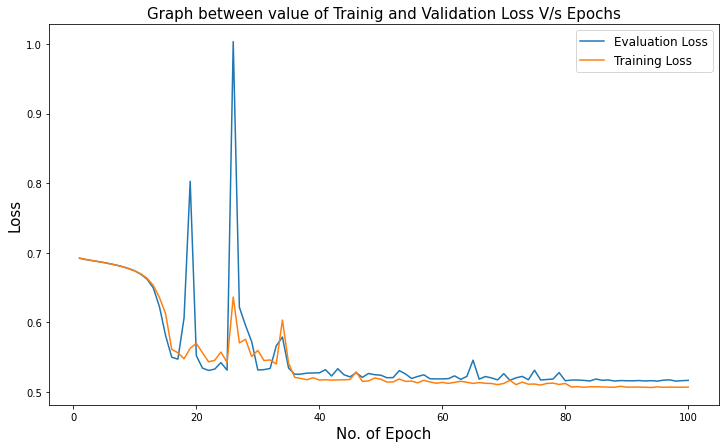



__________________________________________________




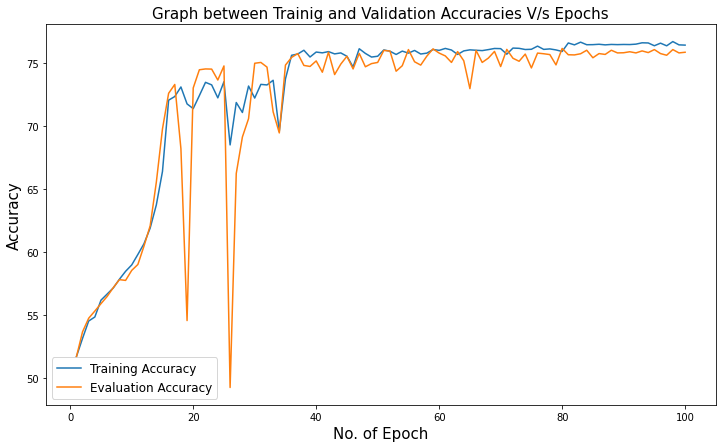

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

## **Trying some other learning rate scheduler-**

### **CYCLIC LR-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn1(packed_embedded)
        packed_output, hidden = self.rnn2(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.7, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn1): RNN(100, 256)
  (rnn2): RNN(256, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn1.weight_ih_l0 	 torch.Size([256, 100])
rnn1.weight_hh_l0 	 torch.Size([256, 256])
rnn1.bias_ih_l0 	 torch.Size([256])
rnn1.bias_hh_l0 	 torch.Size([256])
rnn2.weight_ih_l0 	 torch.Size([256, 256])
rnn2.weight_hh_l0 	 torch.Size([256, 256])
rnn2.bias_ih_l0 	 torch.Size([256])
rnn2.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'initial_lr': 0.001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
The model has 2,723,689 trainable parameter

In [ ]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.691 | Train Acc: 52.62%
	 Val. Loss: 0.688 |  Val. Acc: 54.89%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.686 | Train Acc: 55.55%
	 Val. Loss: 0.683 |  Val. Acc: 57.14%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.679 | Train Acc: 57.07%
	 Val. Loss: 0.675 |  Val. Acc: 58.43%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.666 | Train Acc: 59.66%
	 Val. Loss: 0.656 |  Val. Acc: 61.22%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.644 | Train Acc: 62.54%
	 Val. Loss: 0.624 |  Val. Acc: 65.54%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.626 | Train Acc: 64.75%
	 Val. Loss: 0.772 |  Val. Acc: 58.85%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.614 | Train Acc: 65.99%
	 Val. Loss: 0.563 |  Val. Acc: 71.37%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.636 | Train Acc: 63.97%
	 Val. Loss: 0.598 |  Val. Acc: 69.22%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.615 | Train Acc: 66.18%
	 Val. Loss: 0.597 |  Val. Acc: 68.24%
Epoch: 10 | Epoch T

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.690800,52.617473,0.687920,54.890537
1,2,0.685598,55.546956,0.682579,57.137182
2,3,0.679005,57.066280,0.674631,58.430438
3,4,0.666179,59.655240,0.655640,61.224400
4,5,0.644120,62.542362,0.624202,65.541137
...,...,...,...,...,...
95,96,0.455293,78.871220,0.644240,66.768185
96,97,0.443799,79.193007,0.732840,64.080155
97,98,0.425158,80.476082,0.726713,62.985523
98,99,0.421740,80.419871,0.805297,62.601518


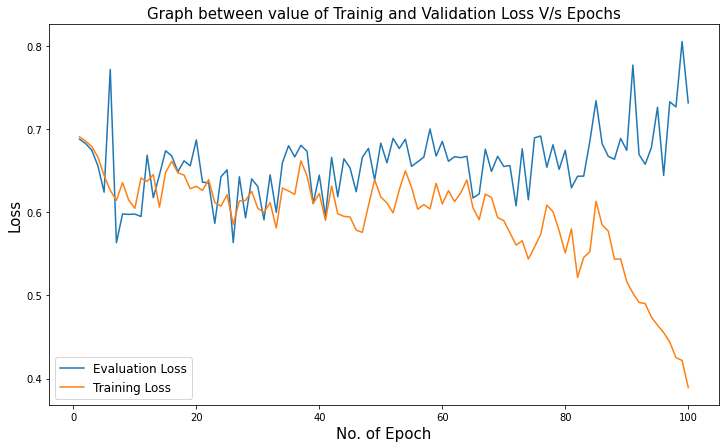



__________________________________________________




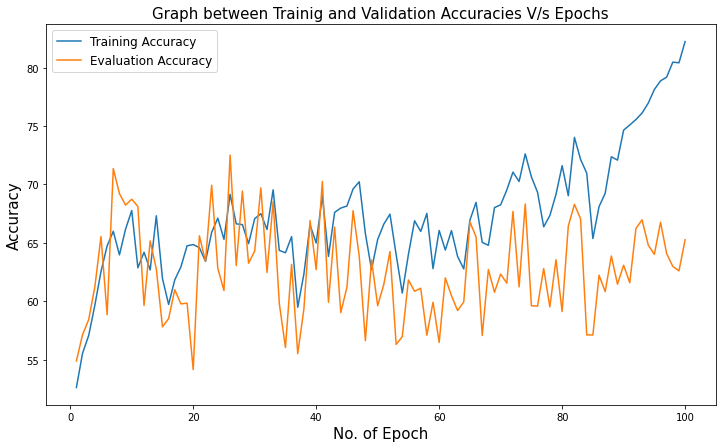

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

### **Trying STEP LR-**

In [24]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn1(packed_embedded)
        packed_output, hidden = self.rnn2(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.7, weight_decay=0.0001)
lambda1 = lambda epoch: 0.1 * (epoch)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=0.01, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn1): RNN(100, 256)
  (rnn2): RNN(256, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Adjusting learning rate of group 0 to 1.0000e-02.
Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn1.weight_ih_l0 	 torch.Size([256, 100])
rnn1.weight_hh_l0 	 torch.Size([256, 256])
rnn1.bias_ih_l0 	 torch.Size([256])
rnn1.bias_hh_l0 	 torch.Size([256])
rnn2.weight_ih_l0 	 torch.Size([256, 256])
rnn2.weight_hh_l0 	 torch.Size([256, 256])
rnn2.bias_ih_l0 	 torch.Size([256])
rnn2.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'initial_lr': 0.01, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [25]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.689 | Train Acc: 53.74%
	 Val. Loss: 0.685 |  Val. Acc: 54.04%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.670 | Train Acc: 58.77%
	 Val. Loss: 0.654 |  Val. Acc: 61.60%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.646 | Train Acc: 62.36%
	 Val. Loss: 0.654 |  Val. Acc: 60.85%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.632 | Train Acc: 64.20%
	 Val. Loss: 0.681 |  Val. Acc: 56.04%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.624 | Train Acc: 65.36%
	 Val. Loss: 0.601 |  Val. Acc: 68.34%
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.667 | Train Acc: 58.33%
	 Val. Loss: 0.694 |  Val. Acc: 56.03%
Adjusting learning rate of group 0 to 1.0000e-

In [27]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.688508,53.735988,0.684840,54.038665
1,2,0.669756,58.766456,0.653516,61.603990
2,3,0.645946,62.359065,0.654305,60.853637
3,4,0.631526,64.203435,0.680545,56.042549
4,5,0.623561,65.356165,0.601000,68.335099
...,...,...,...,...,...
95,96,0.632690,64.445386,0.652289,61.714336
96,97,0.632609,64.438054,0.652289,61.714336
97,98,0.632601,64.467381,0.652289,61.714336
98,99,0.632682,64.438054,0.652289,61.714336


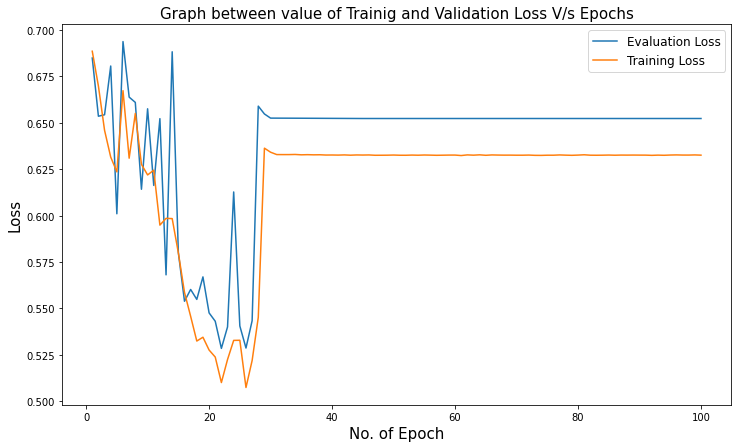



__________________________________________________




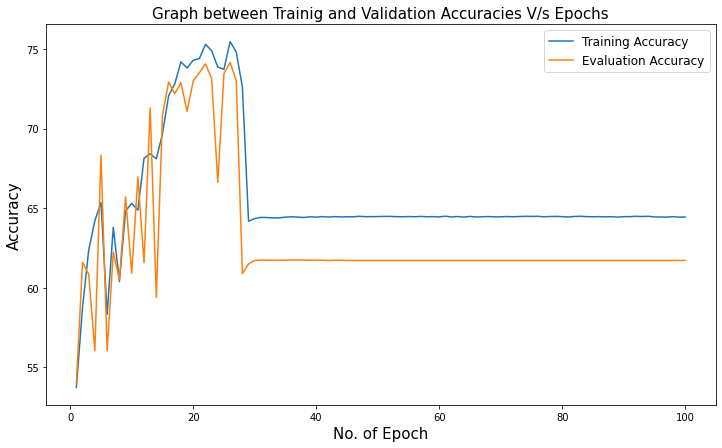

In [28]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

## **Adding 3 layers-**

### **With multistep LR-**

In [17]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.rnn3 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn1(packed_embedded)
        packed_output, hidden = self.rnn2(packed_output)
        packed_output, hidden = self.rnn3(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.7, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn1): RNN(100, 256)
  (rnn2): RNN(256, 256)
  (rnn3): RNN(256, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
________________________________________________________________________


Adjusting learning rate of group 0 to 1.0000e-03.
Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn1.weight_ih_l0 	 torch.Size([256, 100])
rnn1.weight_hh_l0 	 torch.Size([256, 256])
rnn1.bias_ih_l0 	 torch.Size([256])
rnn1.bias_hh_l0 	 torch.Size([256])
rnn2.weight_ih_l0 	 torch.Size([256, 256])
rnn2.weight_hh_l0 	 torch.Size([256, 256])
rnn2.bias_ih_l0 	 torch.Size([256])
rnn2.bias_hh_l0 	 torch.Size([256])
rnn3.weight_ih_l0 	 torch.Size([256, 256])
rnn3.weight_hh_l0 	 torch.Size([256, 256])
rnn3.bias_ih_l0 	 torch.Size([256])
rnn3.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_di

In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    lr_scheduler.step()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
N_EPOCHS = 100

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.694 | Train Acc: 49.86%
	 Val. Loss: 0.693 |  Val. Acc: 50.36%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.693 | Train Acc: 51.01%
	 Val. Loss: 0.692 |  Val. Acc: 52.22%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.692 | Train Acc: 52.88%
	 Val. Loss: 0.691 |  Val. Acc: 53.35%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.690 | Train Acc: 54.29%
	 Val. Loss: 0.690 |  Val. Acc: 53.55%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.689 | Train Acc: 54.96%
	 Val. Loss: 0.689 |  Val. Acc: 55.10%
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.688 | Train Acc: 55.97%
	 Val. Loss: 0.688 |  Val. Acc: 55.14%
Adjusting learning rate of group 0 to 1.0000e-

In [20]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.694219,49.859065,0.693278,50.357521
1,2,0.692657,51.014240,0.692235,52.215749
2,3,0.691531,52.878161,0.691294,53.350106
3,4,0.690396,54.293209,0.690449,53.548729
4,5,0.689220,54.960408,0.688979,55.102401
...,...,...,...,...,...
95,96,0.701663,50.307123,0.697697,51.302083
96,97,0.700747,50.413028,0.696951,51.315325
97,98,0.699964,50.443985,0.696231,51.315325
98,99,0.699010,50.514859,0.695536,51.368291


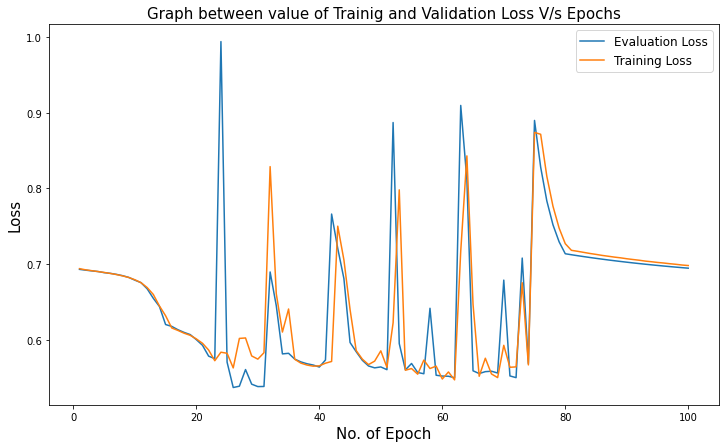



__________________________________________________




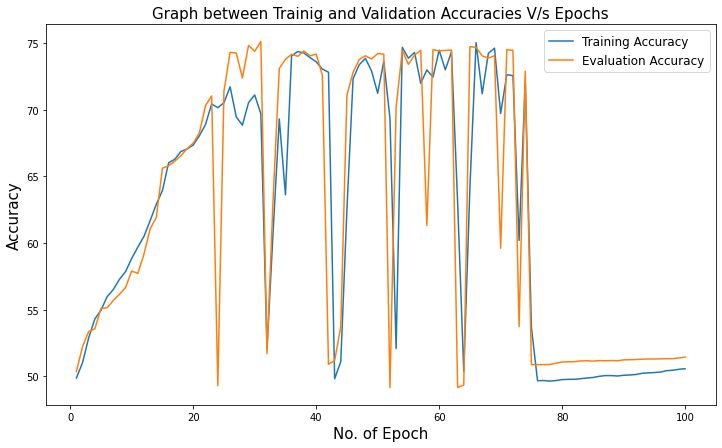

In [21]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

### **BI-Directional RNN with 3 layers-**

In [35]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn3 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn1(packed_embedded)
        # packed_output, hidden = self.rnn2(packed_output)
        # packed_output, hidden = self.rnn3(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.7, weight_decay=0.0001)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn1): RNN(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn1.weight_ih_l0 	 torch.Size([256, 100])
rnn1.weight_hh_l0 	 torch.Size([256, 256])
rnn1.bias_ih_l0 	 torch.Size([256])
rnn1.bias_hh_l0 	 torch.Size([256])
rnn1.weight_ih_l0_reverse 	 torch.Size([256, 100])
rnn1.weight_hh_l0_reverse 	 torch.Size([256, 256])
rnn1.bias_ih_l0_reverse 	 torch.Size([256])
rnn1.bias_hh_l0_reverse 	 torch.Size([256])
rnn1.weight_ih_l1 	 torch.Size([256, 512])
rnn1.weight_hh_l1 	 torch.Size([256, 256])
rnn1.bias_ih_l1 	 torch.Size([256])
rnn1.bias_hh_l1 	 torch.Size([256])
rnn1.weight_ih_l1_reverse 	 torch.Size([256, 512])
rnn1.weight_hh_l1_reverse 	 torch.Size([256, 25

In [36]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    # lr_scheduler.step()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
N_EPOCHS = 10

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.696 | Train Acc: 54.92%
	 Val. Loss: 0.671 |  Val. Acc: 58.71%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 0.682 | Train Acc: 56.92%
	 Val. Loss: 0.675 |  Val. Acc: 57.14%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.683 | Train Acc: 56.45%
	 Val. Loss: 0.681 |  Val. Acc: 56.20%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 0.672 | Train Acc: 59.02%
	 Val. Loss: 0.672 |  Val. Acc: 57.94%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.661 | Train Acc: 60.90%
	 Val. Loss: 0.646 |  Val. Acc: 61.94%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.644 | Train Acc: 62.41%
	 Val. Loss: 0.639 |  Val. Acc: 62.66%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.625 | Train Acc: 64.85%
	 Val. Loss: 0.624 |  Val. Acc: 64.40%
Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.604 | Train Acc: 66.67%
	 Val. Loss: 0.612 |  Val. Acc: 65.21%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.577 | Train Acc: 69.88%
	 Val. Loss: 0.550 |  Val. Acc: 71.83%
Epoch: 10 | Epoch T

In [38]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.695616,54.915602,0.670852,58.712924
1,2,0.682227,56.923716,0.675386,57.141596
2,3,0.683052,56.451219,0.681424,56.197034
3,4,0.671529,59.016554,0.672036,57.936088
4,5,0.660574,60.895953,0.645765,61.935028
5,6,0.644316,62.413647,0.639068,62.658898
6,7,0.624685,64.854340,0.624333,64.397952
7,8,0.604023,66.674270,0.611556,65.214513
8,9,0.576809,69.880735,0.550402,71.830862
9,10,0.566466,70.908010,0.610911,66.684322


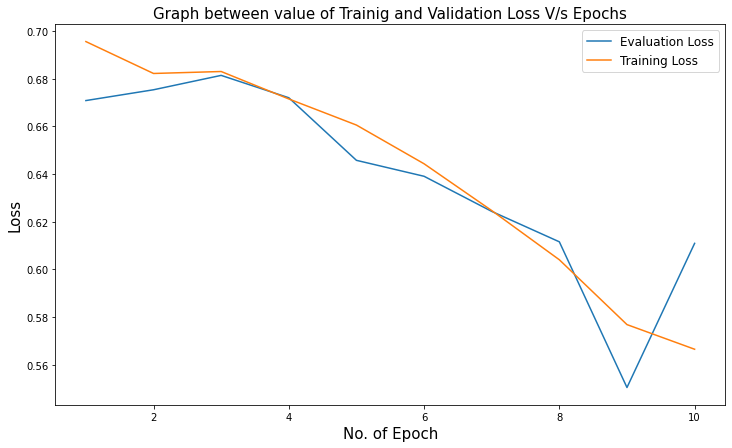



__________________________________________________




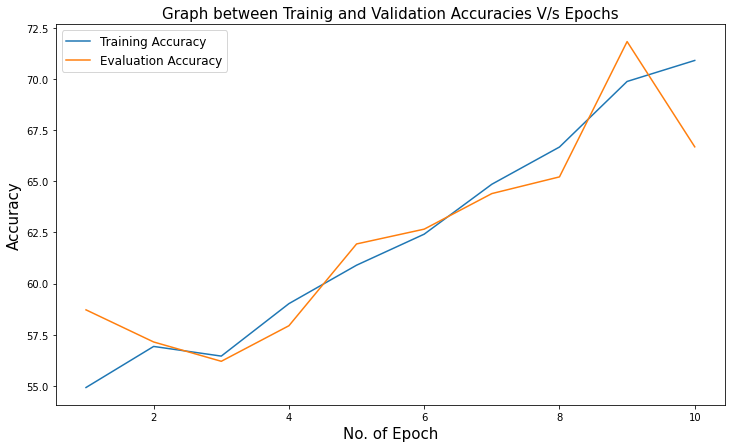

In [39]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

# **LSTM-**

## **LSTM with constant LR-**

In [102]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn3 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # packed_output, hidden = self.rnn2(packed_output)
        # packed_output, hidden = self.rnn3(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.7, weight_decay=0.0001)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([1024, 100])
rnn.weight_hh_l0 	 torch.Size([1024, 256])
rnn.bias_ih_l0 	 torch.Size([1024])
rnn.bias_hh_l0 	 torch.Size([1024])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,867,049 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [103]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    # lr_scheduler.step()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [104]:
N_EPOCHS = 100

best_valid_loss = float('inf')
prev_epoch_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
patience = 3
i = 0
max_epochs = 50
# while i<patience:
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, valid_loss))
        torch.save(model.state_dict(), 'tut1-model.pt')

    if valid_loss_list[-1]<prev_epoch_valid_loss:
      i = 0
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on if condition and the value of i is = ", i)
    else:
      i = i + 1
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on else condition and the value of i is = ", i)
    if i>=patience:
      print("Early Stopping")
      print("Returning the model with best parameters")
      break
    if epoch >= max_epochs:
      print("Max Epochs reached")
      print("Returning the model with best parameters")
      break

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.667 | Train Acc: 58.58%
	 Val. Loss: 0.592 |  Val. Acc: 68.24%
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.59207843
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.546 | Train Acc: 73.04%
	 Val. Loss: 0.428 |  Val. Acc: 81.86%
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.42846583
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.503 | Train Acc: 76.19%
	 Val. Loss: 0.464 |  Val. Acc: 79.48%
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 0.435 | Train Acc: 80.04%
	 Val. Loss: 0.339 |  Val. Acc: 86.19%
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.33905686
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.327 | Train Acc: 86.68%
	 Val. Loss: 0.323 |  Val. Acc: 87.73%
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.32342212
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.277 | Train Acc: 88.99%
	 Val. Loss: 0.299 |  Val. Acc: 88.78%
Saving the model state dict

In [105]:
import pandas as pd
pd = TabularFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.666978,58.579901,0.592078,68.242408
1,2,0.545879,73.039950,0.428466,81.863524
2,3,0.502882,76.188575,0.463545,79.480049
3,4,0.435290,80.036171,0.339057,86.189089
4,5,0.327299,86.678017,0.323422,87.725106
5,6,0.277458,88.994884,0.299214,88.784428
6,7,0.230788,91.020920,0.278358,89.247881
7,8,0.207403,92.180168,0.316330,89.177260
8,9,0.187494,92.849811,0.271946,89.208157
9,10,0.160923,93.904784,0.291149,89.314089


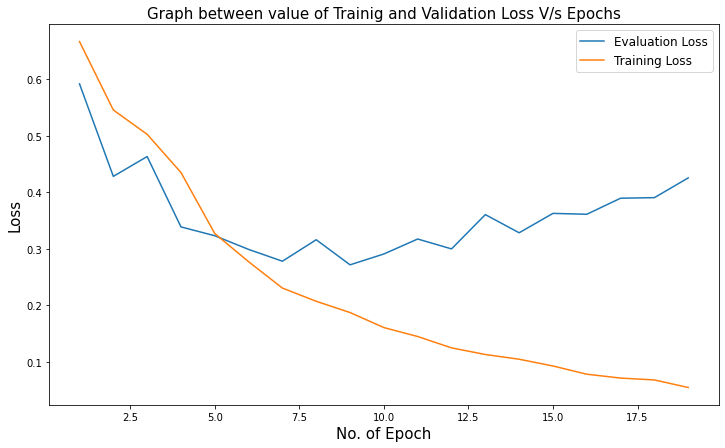



__________________________________________________




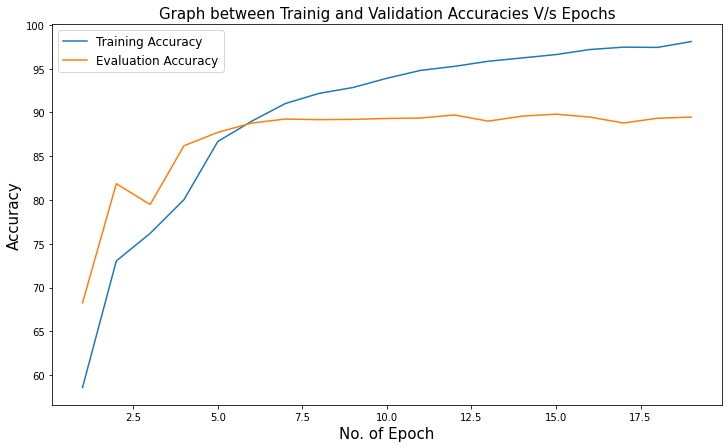

In [106]:
GraphicalFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

## **LSTM with Constant LR with SGD Optimizer-**

In [28]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn3 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # packed_output, hidden = self.rnn2(packed_output)
        # packed_output, hidden = self.rnn3(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.7, weight_decay=0.0001)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
0
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([1024, 100])
rnn.weight_hh_l0 	 torch.Size([1024, 256])
rnn.bias_ih_l0 	 torch.Size([1024])
rnn.bias_hh_l0 	 torch.Size([1024])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,867,049 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [29]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    # lr_scheduler.step()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
N_EPOCHS = 100

best_valid_loss = float('inf')
prev_epoch_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
patience = 3
i = 0
max_epochs = 50
# while i<patience:
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, valid_loss))
        torch.save(model.state_dict(), 'tut1-model.pt')

    if valid_loss_list[-1]<prev_epoch_valid_loss:
      i = 0
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on if condition and the value of i is = ", i)
    else:
      i = i + 1
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on else condition and the value of i is = ", i)
    if i>=patience:
      print("Early Stopping")
      print("Returning the model with best parameters")
      break
    if epoch >= max_epochs:
      print("Max Epochs reached")
      print("Returning the model with best parameters")
      break

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.696 | Train Acc: 49.39%
	 Val. Loss: 0.693 |  Val. Acc: 50.78%
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.69301445
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.693 | Train Acc: 50.18%
	 Val. Loss: 0.693 |  Val. Acc: 50.29%
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.69260397
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.693 | Train Acc: 50.54%
	 Val. Loss: 0.693 |  Val. Acc: 52.37%
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.69251379
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.693 | Train Acc: 50.96%
	 Val. Loss: 0.692 |  Val. Acc: 51.62%
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.69247207
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.693 | Train Acc: 52.03%
	 Val. Loss: 0.692 |  Val. Acc: 51.94%
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.69233008
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.692 | Train A

In [31]:
import pandas as pd
pd = TabularFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.695538,49.394715,0.693014,50.776836
1,2,0.693307,50.179223,0.692604,50.291314
2,3,0.692796,50.541743,0.692514,52.365819
3,4,0.692676,50.958029,0.692472,51.619880
4,5,0.692531,52.030110,0.692330,51.937677
5,6,0.692220,52.267173,0.692239,51.809675
6,7,0.691965,52.059437,0.692079,51.990643
7,8,0.691854,52.482241,0.691945,52.017126
8,9,0.691673,53.120112,0.691776,52.414372
9,10,0.691614,52.930298,0.691635,52.665960


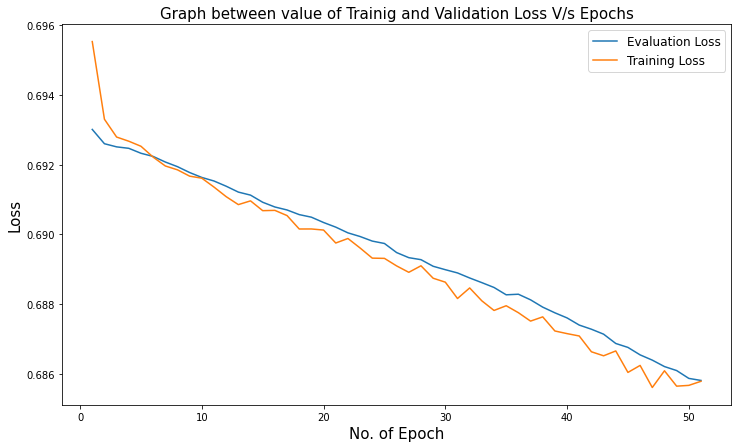



__________________________________________________




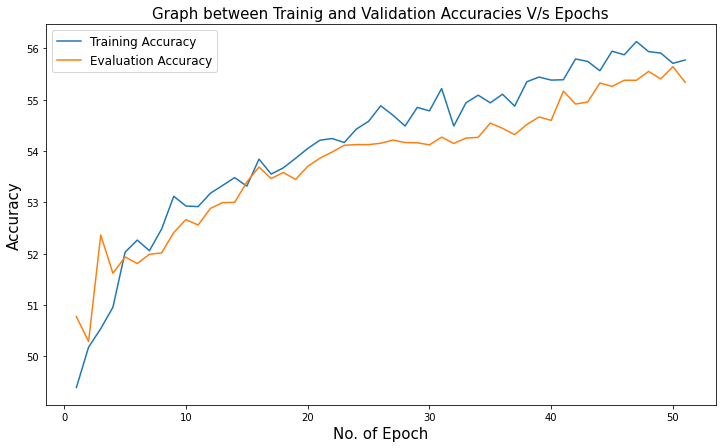

In [32]:
GraphicalFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

### **Increasing the epochs and learning rate-**

In [33]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn3 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # packed_output, hidden = self.rnn2(packed_output)
        # packed_output, hidden = self.rnn3(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.7, weight_decay=0.0001)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
0
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([1024, 100])
rnn.weight_hh_l0 	 torch.Size([1024, 256])
rnn.bias_ih_l0 	 torch.Size([1024])
rnn.bias_hh_l0 	 torch.Size([1024])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.7, 'dampening': 0, 'weight_decay': 0.0001, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,867,049 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [34]:
N_EPOCHS = 100

best_valid_loss = float('inf')
prev_epoch_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
patience = 3
i = 0
max_epochs = 100
# while i<patience:
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, valid_loss))
        torch.save(model.state_dict(), 'tut1-model.pt')

    if valid_loss_list[-1]<prev_epoch_valid_loss:
      i = 0
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on if condition and the value of i is = ", i)
    else:
      i = i + 1
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on else condition and the value of i is = ", i)
    if i>=patience:
      print("Early Stopping")
      print("Returning the model with best parameters")
      break
    if epoch >= max_epochs:
      print("Max Epochs reached")
      print("Returning the model with best parameters")
      break

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 0.693 | Train Acc: 51.05%
	 Val. Loss: 0.692 |  Val. Acc: 54.37%
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.69157468
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.691 | Train Acc: 53.64%
	 Val. Loss: 0.690 |  Val. Acc: 53.83%
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.69024731
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.689 | Train Acc: 54.57%
	 Val. Loss: 0.689 |  Val. Acc: 54.96%
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.68872637
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.687 | Train Acc: 55.44%
	 Val. Loss: 0.687 |  Val. Acc: 55.59%
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.68716116
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.687 | Train Acc: 55.29%
	 Val. Loss: 0.687 |  Val. Acc: 54.70%
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.68658951
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.684 | Train 

In [35]:
import pandas as pd
pd = TabularFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.692919,51.051714,0.691575,54.369703
1,2,0.690875,53.640674,0.690247,53.831215
2,3,0.689454,54.571820,0.688726,54.956744
3,4,0.687496,55.436164,0.687161,55.592338
4,5,0.686871,55.286268,0.686590,54.696328
5,6,0.684418,56.096031,0.683543,56.625177
6,7,0.681684,56.983186,0.680631,57.441737
7,8,0.679000,57.512709,0.677145,57.627119
8,9,0.676205,57.858120,0.673780,58.046434
9,10,0.672716,58.951382,0.664385,60.858051


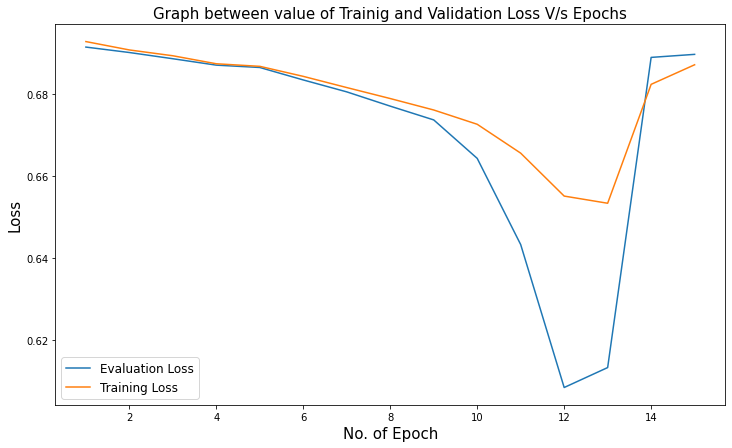



__________________________________________________




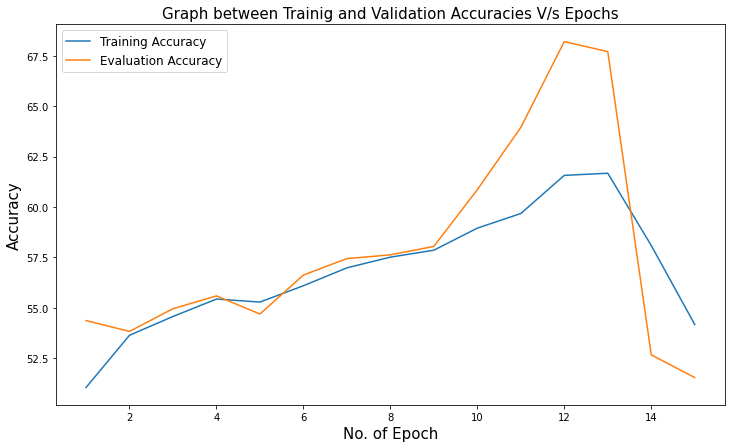

In [36]:
GraphicalFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

# **GRU-**

In [46]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn2 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        # self.rnn3 = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        # packed_output, hidden = self.rnn2(packed_output)
        # packed_output, hidden = self.rnn3(packed_output)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.7, weight_decay=0.0001)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35,80], gamma=0.1, last_epoch=- 1, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

The overall model is - 

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): GRU(100, 256, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
________________________________________________________________________


Model's state_dict:
embedding.weight 	 torch.Size([25002, 100])
rnn.weight_ih_l0 	 torch.Size([768, 100])
rnn.weight_hh_l0 	 torch.Size([768, 256])
rnn.bias_ih_l0 	 torch.Size([768])
rnn.bias_hh_l0 	 torch.Size([768])
fc.weight 	 torch.Size([1, 256])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6]}]
The model has 2,775,401 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [47]:
N_EPOCHS = 100

best_valid_loss = float('inf')
prev_epoch_valid_loss = float('inf')
prev_epoch_train_acc = 0
prev_epoch_valid_acc = 0
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
patience = 3
i = 0
difference = 5
j = 0
max_epochs = 50
# while i<patience:
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, valid_loss))
        torch.save(model.state_dict(), 'tut1-model.pt')

    if valid_loss_list[-1]<prev_epoch_valid_loss:
      i = 0
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on if condition and the value of i is = ", i)
    else:
      i = i + 1
      prev_epoch_valid_loss = valid_loss_list[-1]
      # print (" For ",epoch+1," epoch, gone on else condition and the value of i is = ", i)
    if i>=patience:
      print("Early Stopping")
      print("Returning the model with best parameters")
      break
    if epoch >= max_epochs:
      print("Max Epochs reached")
      print("Returning the model with best parameters")
      break

    if train_acc_list[-1] - valid_acc_list[-1] < difference:
      j = 0

    else:
      print("Model has started to Over train.")
      j = j+1

    if j>3:
      print("Model overtrained for continious 3 epochs. STOPPING THE TRAINING and returning the best parameters.")
      break

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.660 | Train Acc: 60.46%
	 Val. Loss: 0.632 |  Val. Acc: 65.58%
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.63203820
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.495 | Train Acc: 76.00%
	 Val. Loss: 0.481 |  Val. Acc: 81.51%
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.48133733
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.319 | Train Acc: 86.59%
	 Val. Loss: 0.279 |  Val. Acc: 88.83%
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.27910971
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.254 | Train Acc: 89.83%
	 Val. Loss: 0.312 |  Val. Acc: 87.75%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.218 | Train Acc: 91.46%
	 Val. Loss: 0.296 |  Val. Acc: 88.01%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.180 | Train Acc: 92.90%
	 Val. Loss: 0.256 |  Val. Acc: 90.40%
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.25621746
Epoch: 07 | Epoch Time: 0m 7s
	T

In [44]:
import pandas as pd
pd = TabularFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,0.674956,57.728591,0.586266,68.789725
1,2,0.461748,78.566541,0.316162,86.939442
2,3,0.313745,86.867831,0.283347,88.378355
3,4,0.249468,89.847823,0.282307,88.272422
4,5,0.210739,91.653904,0.251966,89.958510
5,6,0.178614,93.288908,0.267906,89.450918
6,7,0.147984,94.450600,0.257186,90.607345
7,8,0.129904,95.011079,0.250318,90.739760
8,9,0.108551,95.926747,0.320023,90.223340
9,10,0.094831,96.521442,0.304176,90.726518


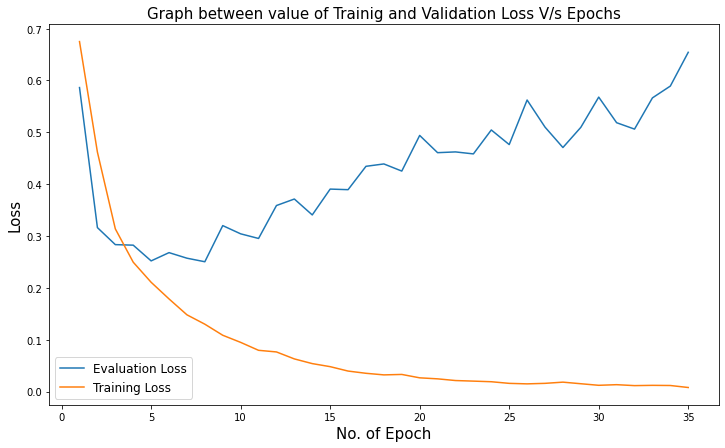



__________________________________________________




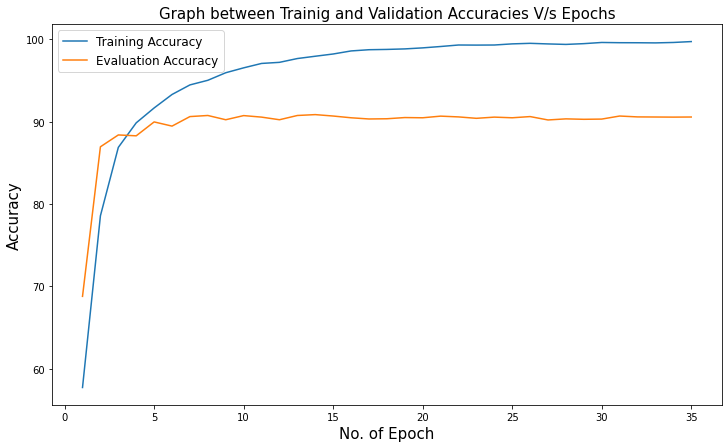

In [45]:
GraphicalFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

# **Testing-**

In [48]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    if prediction.item()>0.5:
      return 'Positive'
    else:
      return 'Negative'
    # return prediction.item()

In [49]:
predict_sentiment(model, "This movie is really good")

'Positive'

In [50]:
predict_sentiment(model, "I have never seen a movie worse than this")

'Negative'

In [51]:
predict_sentiment(model, "You can watch this movie")

'Positive'

In [54]:
predict_sentiment(model, "You should watch this movie only if you don't have anything to do in life.")

'Negative'

In [55]:
predict_sentiment(model, "Please..I request you to never watch this movie!!")

'Negative'

In [56]:
predict_sentiment(model, "boycott this movie")

'Negative'

In [57]:
predict_sentiment(model, "An outstanding and brilliantly made movie after a long time. Usually, I do not encourage bollywood movies but this movie has a storyline that needs your patience and a full on theatrical retreat. ")

'Positive'

In [58]:
predict_sentiment(model, "Movie is an average entertainer.. first half is boring..  jumping from one scene from another .. Content and timing of dialogues are utter nonsense,  seems to be written by inexperienced person .. Ranbir kapoor is good , tried his best with poor dialogues ... alia - Ranbir love story is over emphasized , forceful introduction of alia in few scenes when it was not required .. and body movements of Ranbir during visions was totally hilarious ..Second half was better ... but use of words like button , bhasad seems imbecile with movie titles like brahmastra .. and doing ending like bahubali lacks originality .. Vfx were good ..Bolloywood needs some originality , brains and better script writing and mature content .. Brahmastra is just one time watch .. only if you have time and longing for a time pass movie..")

'Negative'

In [59]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.256 | Test Acc: 89.93%
